### 基于规则的模型：Persistence model
简单将前一天的值当作今天的预测

本文件基于时间划分测试集和训练集

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/result.array'
transplant_arr_path = r'../output/transplant/old_school_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, 1:-1, :]
transplant_arr = transplant_arr[:, 1:-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 15, 11)
Shape of the transplant array: (5141, 15, 11)


### 规范数据并获取训练集和测试集

In [4]:
scaler, data = scale_data(transplant_arr, 'none')
X_train, X_test, y_train, y_test = split_data_by_time(data, 6, 5, False)

### 构建模型

In [5]:
def enhanced_persistence_model_predict(X, y):
    es_x = X[:, -1, -2].reshape(len(X), 1)
    es_y = y[:, :-1]
    return np.hstack((es_x, es_y))

def persistence_model_predict(X, y):
    timesteps = y.shape[1]
    result = np.zeros((X.shape[0], timesteps))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i][j] = X[i, -1, -2]
    return result

预测

In [6]:
X_test.shape

(5141, 6, 11)

In [7]:
y_pred = enhanced_persistence_model_predict(X_test, y_test).reshape(y_test.shape)

画图

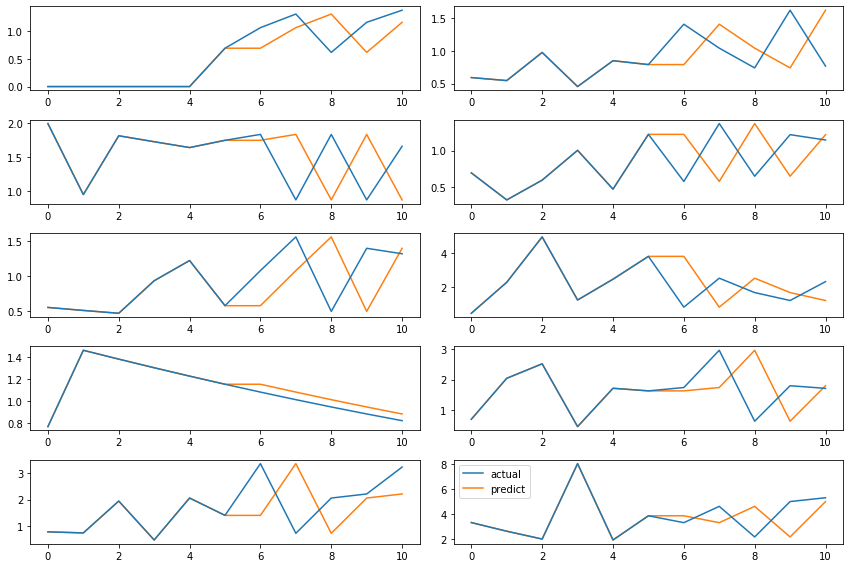

In [8]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

评估

MAE: 1.0275896239448195
MAEMAE: [1.0365444  1.06998802 1.04143001 0.99403172 0.99595397]


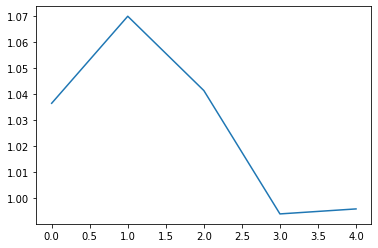

NDCG: 0.7833772222682579
NDCGMAE: [5.4307264904991166e-05, 9.35145045437989e-05, 4.062222315988897e-05, 0.0005724893161398619, 0.00011937923001829725]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


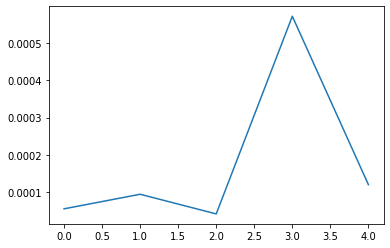

In [9]:
metrics = ['mae', 'ndcg']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred, scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}MAE:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [52]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [53]:
from sklearn.metrics import classification_report
print(classification_report(_y_true[:,1].reshape(-1), _y_pred[:,1].reshape(-1)))

              precision    recall  f1-score   support

         1.0       0.62      0.62      0.62      2883
         2.0       0.26      0.25      0.25      1431
         3.0       0.21      0.23      0.22       506
         4.0       0.22      0.21      0.22       321

    accuracy                           0.45      5141
   macro avg       0.33      0.33      0.33      5141
weighted avg       0.45      0.45      0.45      5141

